For that lab we will need keras, so go to your python.exe location and run:

`python -m pip install keras`

That will install keras and tensorflow libraries for you.

For model visualization we will also need [graphviz](https://graphviz.gitlab.io/download/) lib, so also please navigate to the link and install it, also adding it ti PATH variable.

We will work firstly with pretrained model:

In [1]:
import keras

model = keras.applications.vgg16.VGG16()

Using TensorFlow backend.


### Getting weight and layers data 

Let us visualize this model

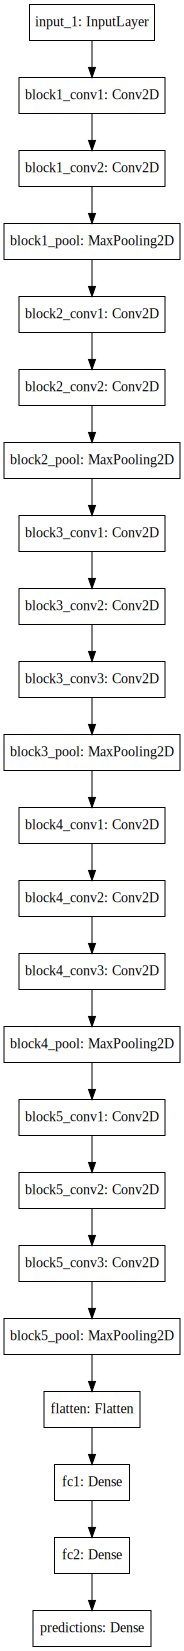

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

And also see the shapes of weights

In [4]:
weights = model.get_weights()
for weight in weights:
    print(weight.shape)

(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(25088, 4096)
(4096,)
(4096, 4096)
(4096,)
(4096, 1000)
(1000,)


In [38]:
out_layers = []
out_shapes = []
layers = model.layers
for layer in layers:
    print(layer.name)
    print(layer.output_shape, '\n')
    out_layers.append(layer.name)
    out_shapes.append(layer.output_shape)

input_1
(None, 224, 224, 3) 

block1_conv1
(None, 224, 224, 64) 

block1_conv2
(None, 224, 224, 64) 

block1_pool
(None, 112, 112, 64) 

block2_conv1
(None, 112, 112, 128) 

block2_conv2
(None, 112, 112, 128) 

block2_pool
(None, 56, 56, 128) 

block3_conv1
(None, 56, 56, 256) 

block3_conv2
(None, 56, 56, 256) 

block3_conv3
(None, 56, 56, 256) 

block3_pool
(None, 28, 28, 256) 

block4_conv1
(None, 28, 28, 512) 

block4_conv2
(None, 28, 28, 512) 

block4_conv3
(None, 28, 28, 512) 

block4_pool
(None, 14, 14, 512) 

block5_conv1
(None, 14, 14, 512) 

block5_conv2
(None, 14, 14, 512) 

block5_conv3
(None, 14, 14, 512) 

block5_pool
(None, 7, 7, 512) 

flatten
(None, 25088) 

fc1
(None, 4096) 

fc2
(None, 4096) 

predictions
(None, 1000) 



You might notice that the number of weights is greater than the number of layers. This is because we also have bias weights, in which we are not currently inerested in.

### Task 1 
Visualize weights from the input layer

(3, 3, 3, 64)
(64, 3, 3, 3)


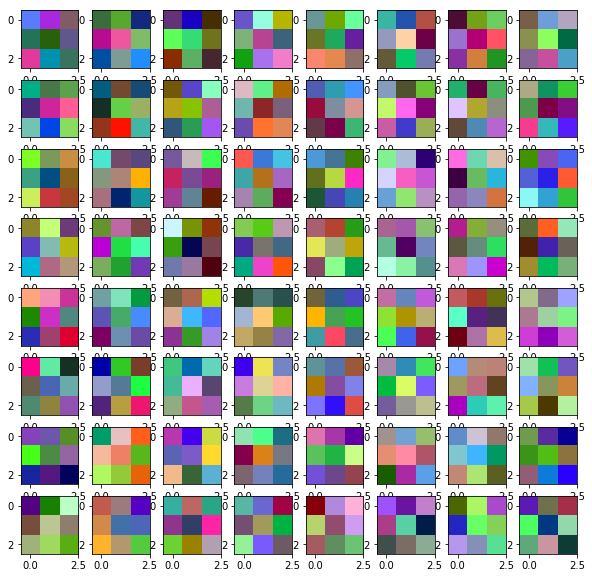

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

weights = np.array(model.layers[1].get_weights())
print(weights[0].shape)

result = weights[0].reshape((64, 3, 3, 3))
print(result.shape)

fig = plt.figure(figsize=(10,10))
for i in range(0, len(result)):
    img = result[i]
    cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
    fig.add_subplot(8,8,i + 1).imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

### Task 2

Feed an image to the model and get an output image from some layer

You can see the output from each layer using this [guide](https://stackoverflow.com/a/41712013)

In [43]:
out_layers = out_layers[1:-4]

In [44]:
out_shapes = out_shapes[1:-4]

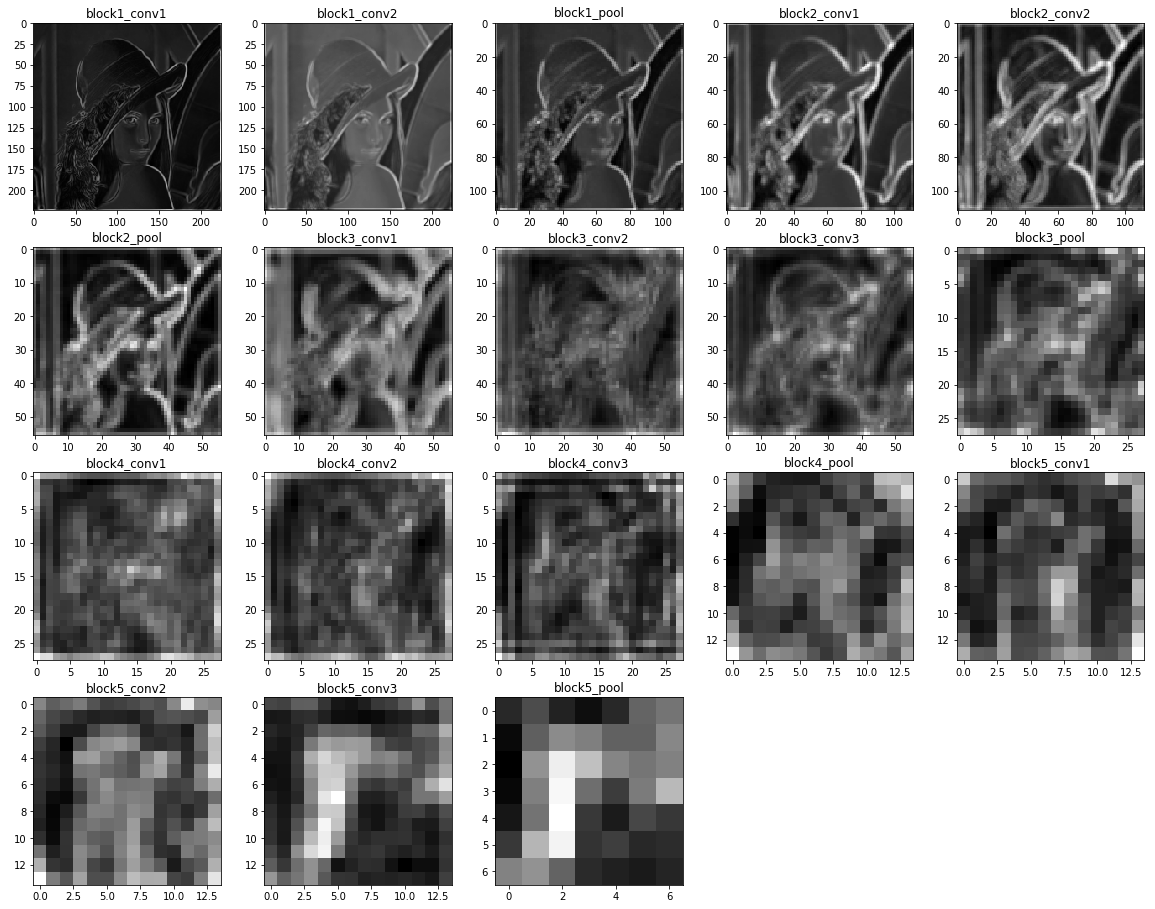

In [57]:
from keras.models import Model

image_path = 'openCV-data/lena.png'
img = cv2.imread(image_path, -1)

resized_image = cv2.resize(img, (224, 224)) 

fig = plt.figure(figsize=(20,20))

for i in range(len(out_layers)):
    layer_name = out_layers[i]
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    
    intermediate_output = intermediate_layer_model.predict(np.array([resized_image]))
    intermediate_output = intermediate_output[0]
    
    result = []
    for k in range(len(intermediate_output)):
        tmp = []
        for l in range(len(intermediate_output[k])):
            tmp.append(sum(intermediate_output[k][l]) / out_shapes[i][-1])
        result.append(tmp)
        
    result = np.array(result)
    
    
    cv2.normalize(result,  result, 0, 255, cv2.NORM_MINMAX)
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(result.astype('uint8'), cmap='gray')
    ax.set_title(out_layers[i])

### Task 3 

Classify cats and dogs images with [features from CNN](https://keras.io/applications/#extract-features-with-vgg16) using SVM/KNN/etc...

In [14]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os

base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

img_path_cats = './dogscats/train/cats/'
img_path_dogs = './dogscats/train/dogs/'

X_cats = []
for file in os.listdir(img_path_cats)[:150]:
    img = image.load_img(img_path_cats + file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_cats.append(x)
X_cats = np.array(X_cats)
X_cats = preprocess_input(X_cats)
y_cats = [0] * len(X_cats)
    
X_dogs = []
for file in os.listdir(img_path_dogs)[:150]:
    img = image.load_img(img_path_dogs + file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_dogs.append(x)
X_dogs = np.array(X_dogs)
X_dogs = preprocess_input(X_dogs)
y_dogs = [1] * len(X_dogs)

In [15]:
features_cats = []
for cat in X_cats:
    features_cats.append(model.predict(cat)[0])

In [16]:
features_dogs = []
for dog in X_dogs:
    features_dogs.append(model.predict(dog)[0])

In [17]:
X = np.concatenate([features_cats, features_dogs])

In [18]:
y = np.concatenate([y_cats, y_dogs])

In [19]:
print(X.shape)
print(y.shape)

(300, 4096)
(300,)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### KNN:

In [21]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
print(neigh.score(X_test, y_test))

0.9797979797979798


### Building your own model

Consider the NON-working example below (x_train not defined)

In [23]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

model = Sequential() # initialize linear stacked model
# create first conv layer and provide input shapes (other shapes will be calculated automatically)
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:])) 
# set activation function for the layer
model.add(Activation('relu'))
#repeat
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# first maxpooling layer with 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))
# set dropout to 25% of neurons number
model.add(Dropout(0.25))

# flatten convert ndarray fron the prev layer to 1D vector
model.add(Flatten())
# fully connected layer with 512 neurons
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

NameError: name 'x_train' is not defined

### Task 4

Create your own simple architecture and train CNN on [MNIST](https://keras.io/datasets/#mnist-database-of-handwritten-digits) dataset. Note that MNIST is 1 color channel dataset.
Test it on some hard images from the web, [such as](https://www.wpclipart.com/education/animal_numbers/animal_number_2.png).

In [24]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import pyprind
import matplotlib.pyplot as plt

In [25]:
batch_size = 128
num_classes = 10
epochs = 12

img_rows, img_cols = 28, 28

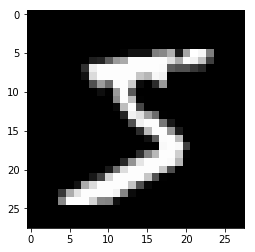

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.imshow(x_train[0],cmap=pyplot.get_cmap('gray'))
plt.show()

In [27]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [28]:
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 13s 211us/step - loss: 0.2695 - acc: 0.9174 - val_loss: 0.0608 - val_acc: 0.9802
Epoch 2/12
60000/60000 [==============================] - 12s 200us/step - loss: 0.0904 - acc: 0.9733 - val_loss: 0.0415 - val_acc: 0.9852
Epoch 3/12
60000/60000 [==============================] - 12s 199us/step - loss: 0.0681 - acc: 0.9798 - val_loss: 0.0354 - val_acc: 0.9881
Epoch 4/12
60000/60000 [==============================] - 12s 198us/step - loss: 0.0559 - acc: 0.9834 - val_loss: 0.0305 - val_acc: 0.9897
Epoch 5/12
60000/60000 [==============================] - 12s 201us/step - loss: 0.0485 - acc: 0.9854 - val_loss: 0.0309 - val_acc: 0.9903
Epoch 6/12
60000/60000 [==============================] - 12s 200us/step - loss: 0.0438 - acc: 0.9870 - val_loss: 0.0315 - val_acc: 0.9903
Epoch 7/12
60000/60000 [==============================] - 12s 200us/step - loss: 0.0376 - acc: 0.9882 - val_loss: 0.

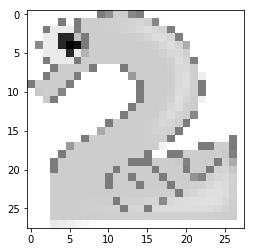

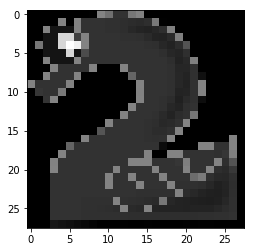

In [30]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import cv2

image_path = './animal_number_2.png'
img = cv2.imread(image_path, 0)

resized_image = cv2.resize(img, (28, 28))
inverted_image = 255 - resized_image

plt.imshow(resized_image,cmap=pyplot.get_cmap('gray'))
plt.show()
plt.imshow(inverted_image,cmap=pyplot.get_cmap('gray'))
plt.show()

In [31]:
import numpy as np

image = resized_image.reshape(1, img_rows, img_cols, 1)

prediction = model.predict(image)
print("Only resized image prediction : {}".format(np.argmax(prediction)))

image = inverted_image.reshape(1, img_rows, img_cols, 1)

prediction = model.predict(image)
print("Resized + inverted colors image prediction : {}".format(np.argmax(prediction)))

Only resized image prediction : 0
Resized + inverted colors image prediction : 2


In [32]:
#model.save("./mnist_model")

from keras.models import load_model

model = load_model('mnist_model')

### Task 5

Augment MNIST data using [ImageDataGenerator](https://keras.io/preprocessing/image/) and color inversion + visualize (or save) augmented images.
Train your model on augmented data and compare the results on your images from the web.

In [33]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import pyprind
import matplotlib.pyplot as plt

In [34]:
batch_size = 128
num_classes = 10
epochs = 12

img_rows, img_cols = 28, 28

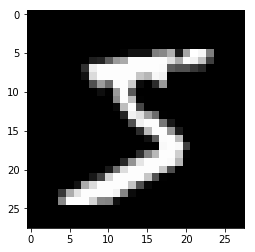

In [35]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.imshow(x_train[0],cmap=pyplot.get_cmap('gray'))
plt.show()

In [36]:
x_train[0].shape

(28, 28)

In [37]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [38]:
x_train_inv = 255 - x_train
y_train_inv = y_train

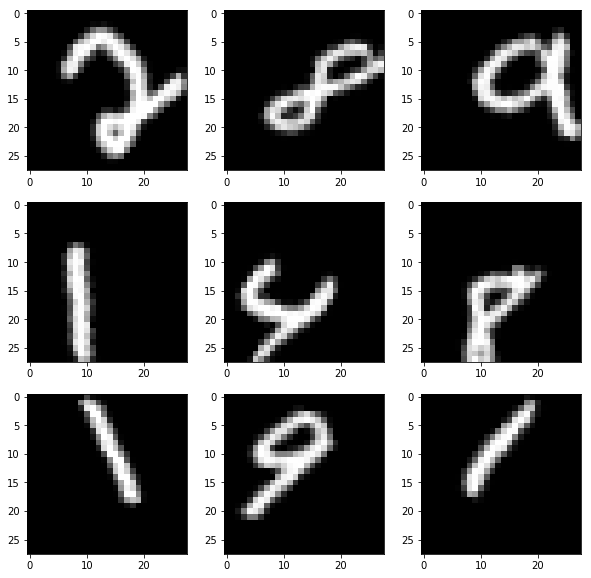

In [39]:
#augmentation without color inversion
shift = 0.2
rotation = 45

datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift, rotation_range=rotation)
datagen.fit(x_train)

x_train_augm = []
y_train_augm = []

index = 0

fig = plt.figure(figsize=(10,10))
for x_augm, y_augm in datagen.flow(x_train, y_train, batch_size=60000):
    for i in range(60000):
        x_train_augm.append(x_augm[i])
        y_train_augm.append(y_augm[i])
        index += 1
        if i < 9:
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(x_augm[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    break

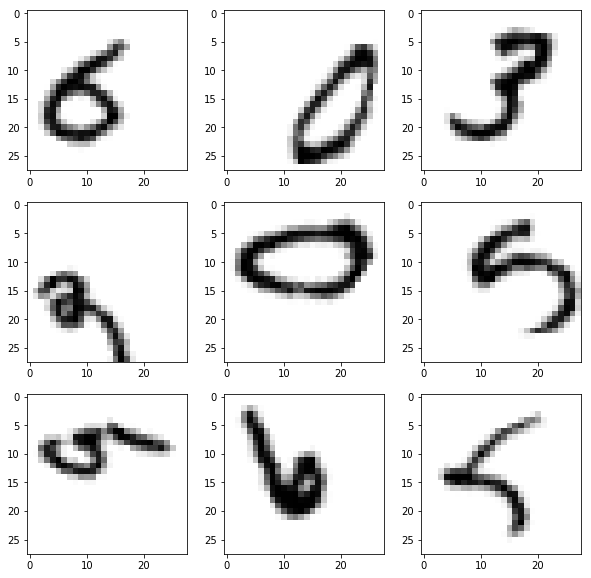

In [40]:
shift = 0.2
rotation = 45

datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift, rotation_range=rotation)
datagen.fit(x_train)

x_train_augm_inv = []
y_train_augm_inv = []

index = 0

fig = plt.figure(figsize=(10,10))
for x_augm, y_augm in datagen.flow(x_train, y_train, batch_size=60000):
    for i in range(60000):
        inverted = 255 - x_augm[i]
        x_train_augm_inv.append(inverted)
        y_train_augm_inv.append(y_augm[i])
        index += 1
        if i < 9:
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(inverted.reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    break

In [41]:
import numpy as np

x_train_augm = np.array(x_train_augm)
print(x_train_augm.shape)

y_train_augm = np.array(y_train_augm)
print(y_train_augm.shape)

(60000, 28, 28, 1)
(60000,)


In [42]:
x_train_augm_inv = np.array(x_train_augm_inv)
print(x_train_augm.shape)

y_train_augm_inv = np.array(y_train_augm_inv)
print(y_train_augm_inv.shape)

(60000, 28, 28, 1)
(60000,)


In [43]:
x_train = np.concatenate((x_train, x_train_inv, x_train_augm, x_train_augm_inv), axis=0)

In [44]:
x_train.shape

(240000, 28, 28, 1)

In [45]:
y_train = np.concatenate((y_train, y_train_inv, y_train_augm, y_train_augm_inv), axis=0)

In [46]:
y_train.shape

(240000,)

In [47]:
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (240000, 28, 28, 1)
240000 train samples
10000 test samples


In [48]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [49]:
model.fit(x_train, y_train, shuffle=True,
          batch_size=batch_size,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 240000 samples, validate on 10000 samples
Epoch 1/12
240000/240000 [==============================] - 47s 194us/step - loss: 0.6519 - acc: 0.7853 - val_loss: 0.0647 - val_acc: 0.9810
Epoch 2/12
240000/240000 [==============================] - 46s 191us/step - loss: 0.3822 - acc: 0.8775 - val_loss: 0.0399 - val_acc: 0.9864
Epoch 3/12
240000/240000 [==============================] - 46s 191us/step - loss: 0.3225 - acc: 0.8979 - val_loss: 0.0383 - val_acc: 0.9871
Epoch 4/12
240000/240000 [==============================] - 46s 192us/step - loss: 0.2893 - acc: 0.9093 - val_loss: 0.0331 - val_acc: 0.9897
Epoch 5/12
240000/240000 [==============================] - 46s 192us/step - loss: 0.2696 - acc: 0.9162 - val_loss: 0.0348 - val_acc: 0.9881
Epoch 6/12
240000/240000 [==============================] - 46s 193us/step - loss: 0.2544 - acc: 0.9219 - val_loss: 0.0329 - val_acc: 0.9891
Epoch 7/12
240000/240000 [==============================] - 46s 192us/step - loss: 0.2434 - acc: 0.9260

In [22]:
model.save("./mnist_model_augm")

#from keras.models import load_model

#model = load_model('mnist_model_augm')

In [50]:
import numpy as np

image = resized_image.reshape(1, img_rows, img_cols, 1)

prediction = model.predict(image)
print("Only resized image prediction : {}".format(np.argmax(prediction)))

image = inverted_image.reshape(1, img_rows, img_cols, 1)

prediction = model.predict(image)
print("Resized + inverted colors image prediction : {}".format(np.argmax(prediction)))

Only resized image prediction : 2
Resized + inverted colors image prediction : 2


### Task 6

[Use](https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/) pretrained model to train on CIFAR-10 dataset. For that, you can try to use your CNN architecture. 

### 1) Pretrained CNN:

In [70]:
import tensorflow as tf

In [71]:
import keras
from keras.datasets import cifar10

In [72]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [73]:
img_rows = 32
img_cols = 32

In [74]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [75]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [76]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

In [77]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0f8304e1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f0f8304e4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f0f8304e438> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0f82eeed30> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82eee780> False
<keras.layers.convolutional.Conv2D object at 0x7f0f833ffcc0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0f82f08668> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82f084e0> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82e70e10> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82e220b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0f82e3e668> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82e3e4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82de2e10> False
<keras.layers.convolutional.Conv2D object at 0x7f0f82d980b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0f82db3668>

In [78]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                10250     
Total params: 15,250,250
Trainable params: 7,614,986
Non-trainable params: 7,635,264
_________________________________________________________________


In [79]:
num_classes = 10

In [80]:
x_train = x_train / 255
x_test = x_test / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [81]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.01, patience=4, verbose=0, mode='max', restore_best_weights=False)
checkpoint = ModelCheckpoint('models1/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')

In [82]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
# Train the model
history = model.fit(x_train, y_train, shuffle=True,
          batch_size=128,
          epochs=60,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping, checkpoint])
 
# Save the model
model.save('small_last4.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.6703 - acc: 0.4078 - val_loss: 1.2186 - val_acc: 0.5829
Epoch 2/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.1977 - acc: 0.5841 - val_loss: 1.0361 - val_acc: 0.6410
Epoch 3/60
50000/50000 [==============================] - 53s 1ms/step - loss: 1.0424 - acc: 0.6404 - val_loss: 0.9515 - val_acc: 0.6698
Epoch 4/60
50000/50000 [==============================] - 53s 1ms/step - loss: 0.9517 - acc: 0.6708 - val_loss: 0.9086 - val_acc: 0.6848
Epoch 5/60
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8893 - acc: 0.6928 - val_loss: 0.8622 - val_acc: 0.6983
Epoch 6/60
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8393 - acc: 0.7085 - val_loss: 0.8285 - val_acc: 0.7109
Epoch 7/60
50000/50000 [==============================] - 53s 1ms/step - loss: 0.7999 - acc: 0.7228 - val_loss: 0.8110 - val_acc

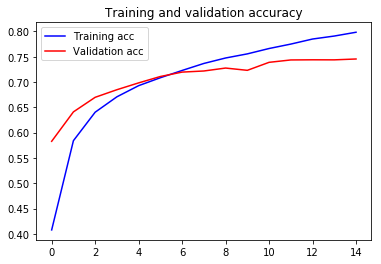

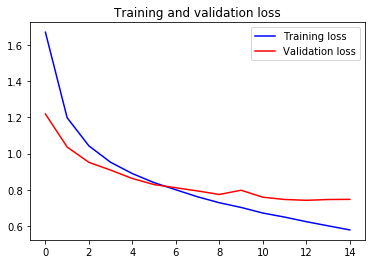

In [83]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [88]:
model.load_weights("./models1/weights.013-0.7439.hdf5")

In [89]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 14s 1ms/step


[0.7416767288208008, 0.7439]

### 2) My CNN:

In [14]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import pyprind
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.01, patience=4, verbose=0, mode='auto', restore_best_weights=False)
checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')

In [16]:
# Train the model
history = model.fit(x_train, y_train, shuffle=True,
          batch_size=128,
          epochs=60,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping, checkpoint])
 
# Save the model
model.save('my_cnn.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 16s 317us/step - loss: 1.8192 - acc: 0.3419 - val_loss: 1.4272 - val_acc: 0.4801
Epoch 2/60
50000/50000 [==============================] - 14s 270us/step - loss: 1.3925 - acc: 0.5038 - val_loss: 1.1625 - val_acc: 0.5998
Epoch 3/60
50000/50000 [==============================] - 14s 271us/step - loss: 1.2124 - acc: 0.5723 - val_loss: 1.0330 - val_acc: 0.6404
Epoch 4/60
50000/50000 [==============================] - 14s 273us/step - loss: 1.0959 - acc: 0.6156 - val_loss: 1.0255 - val_acc: 0.6466
Epoch 5/60
50000/50000 [==============================] - 14s 271us/step - loss: 1.0066 - acc: 0.6456 - val_loss: 0.9384 - val_acc: 0.6771
Epoch 6/60
50000/50000 [==============================] - 14s 271us/step - loss: 0.9266 - acc: 0.6767 - val_loss: 0.8938 - val_acc: 0.6936
Epoch 7/60
50000/50000 [==============================] - 14s 272us/step - loss: 0.8670 - acc: 0.6974 - val_loss: 0.

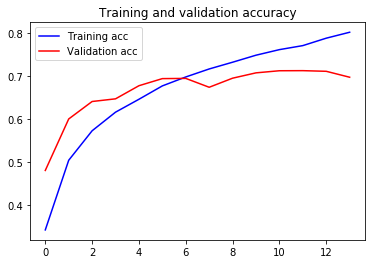

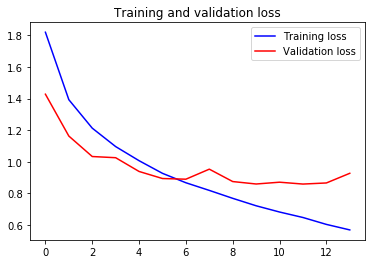

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [18]:
model.load_weights("./models/weights.012-0.7121.hdf5")

In [19]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 149us/step


[0.8587256881713867, 0.7121]

### Task 7

[Implement](https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216) style transfer technique

In [1]:
import numpy as np

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## Specify paths for 1) content image 2) style image and 3) generated image
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##

cImPath = './cat.jpeg'
sImPath = './violin.jpeg'
genImOutputPath = './output.jpeg'

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## Image processing
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

targetHeight = 512
targetWidth = 512
targetSize = (targetHeight, targetWidth)

cImage = load_img(path=cImPath, target_size=targetSize)
cImArr = img_to_array(cImage)
cImArr = K.variable(preprocess_input(np.expand_dims(cImArr, axis=0)), dtype='float32')

sImage = load_img(path=sImPath, target_size=targetSize)
sImArr = img_to_array(sImage)
sImArr = K.variable(preprocess_input(np.expand_dims(sImArr, axis=0)), dtype='float32')

gIm0 = np.random.randint(256, size=(targetWidth, targetHeight, 3)).astype('float64')
gIm0 = preprocess_input(np.expand_dims(gIm0, axis=0))
gImPlaceholder = K.placeholder(shape=(1, targetWidth, targetHeight, 3))

Using TensorFlow backend.


In [2]:
def get_feature_reps(x, layer_names, model):
    """
    Get feature representations of input x for one or more layers in a given model.
    """
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1]*featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices

def get_content_loss(F, P):
    cLoss = 0.5*K.sum(K.square(F - P))
    return cLoss

In [3]:
def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

In [4]:
def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        sLoss+= w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return sLoss

In [5]:
def get_total_loss(gImPlaceholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[cLayerName], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=sLayerNames, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha*contentLoss + beta*styleLoss
    return totalLoss

In [6]:
def calculate_loss(gImArr):
    if gImArr.shape != (1, targetWidth, targetWidth, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
    return loss_fcn([gImArr])[0].astype('float64')

def get_grad(gImArr):
    if gImArr.shape != (1, targetWidth, targetHeight, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    grad_fcn = K.function([gModel.input], 
                          K.gradients(get_total_loss(gModel.input), [gModel.input]))
    grad = grad_fcn([gImArr])[0].flatten().astype('float64')
    return grad

In [7]:
from keras.applications import VGG16
from scipy.optimize import fmin_l_bfgs_b
import time

tf_session = K.get_session()
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=cImArr)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=sImArr)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=gImPlaceholder)
cLayerName = 'block4_conv2'
sLayerNames = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                ]

P = get_feature_reps(x=cImArr, layer_names=[cLayerName], model=cModel)[0]
As = get_feature_reps(x=sImArr, layer_names=sLayerNames, model=sModel)
ws = np.ones(len(sLayerNames))/float(len(sLayerNames))

iterations = 300
x_val = gIm0.flatten()

start = time.time()
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_val, fprime=get_grad, maxiter=iterations, disp=1)
end = time.time()

print('Time taken: {}'.format(end-start))

Time taken: 29824.89999771118


In [8]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (targetWidth, targetHeight, 3):
        x = x.reshape((targetWidth, targetHeight, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x

In [9]:
def save_original_size(x, target_size=targetSize):
    xIm = Image.fromarray(x)
    xIm = xIm.resize(target_size)
    xIm.save(genImOutputPath)
    return xIm

In [10]:
from PIL import Image

In [11]:
xOut = postprocess_array(xopt)
xIm = save_original_size(xOut)
print('Image saved')

Image saved
